In [3]:
import numpy as np
import pymultinest

import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline

import json

import corner

import retrieval_base.auxiliary_functions as af

def read_results(prefix, n_params):

    # Set-up analyzer object
    analyzer = pymultinest.Analyzer(
        n_params=n_params, 
        outputfiles_basename=prefix
        )
    stats = analyzer.get_stats()

    # Load the equally-weighted posterior distribution
    posterior = analyzer.get_equal_weighted_posterior()
    posterior = posterior[:,:-1]

    # Read the parameters of the best-fitting model
    bestfit = np.array(stats['modes'][0]['maximum a posterior'])

    PT = af.pickle_load(prefix+'data/bestfit_PT.pkl')
    Chem = af.pickle_load(prefix+'data/bestfit_Chem.pkl')

    m_spec = af.pickle_load(prefix+'data/bestfit_m_spec_J1226.pkl')
    d_spec = af.pickle_load(prefix+'data/d_spec_J1226.pkl')

    LogLike = af.pickle_load(prefix+'data/bestfit_LogLike_J1226.pkl')

    try:
        Cov = af.pickle_load(prefix+'data/bestfit_Cov.pkl')
    except:
        Cov = None

    int_contr_em           = np.load(prefix+'data/bestfit_int_contr_em_J1226.npy')
    int_contr_em_per_order = np.load(prefix+'data/bestfit_int_contr_em_per_order_J1226.npy')
    int_opa_cloud          = np.load(prefix+'data/bestfit_int_opa_cloud_J1226.npy')

    f = open(prefix+'data/bestfit.json')
    bestfit_params = json.load(f)
    f.close()

    print(posterior.shape)
    return posterior, bestfit, PT, Chem, int_contr_em, int_contr_em_per_order, int_opa_cloud, m_spec, d_spec, LogLike, Cov, bestfit_params

In [11]:
res = read_results(
    prefix='./retrieval_outputs/fiducial_J_B_ret_8/test_', n_params=29
)
posterior, bestfit, PT, Chem, _, _, _, m_spec, d_spec, LogLike, _, bestfit_params = res

pRT_atm = af.pickle_load(
    #'./retrieval_outputs/fiducial_J_B_ret_8/test_data/pRT_atm_broad_J1226.pkl'
    './retrieval_outputs/fiducial_J_B_ret_8/test_data/pRT_atm_J1226.pkl'
    )
pRT_atm.params = bestfit_params['params']


  analysing data from ./retrieval_outputs/fiducial_J_B_ret_8/test_.txt
(2463, 29)


In [15]:
_ = pRT_atm(Chem.mass_fractions, PT.temperature, bestfit_params['params'], get_contr=True, get_full_spectrum=False)

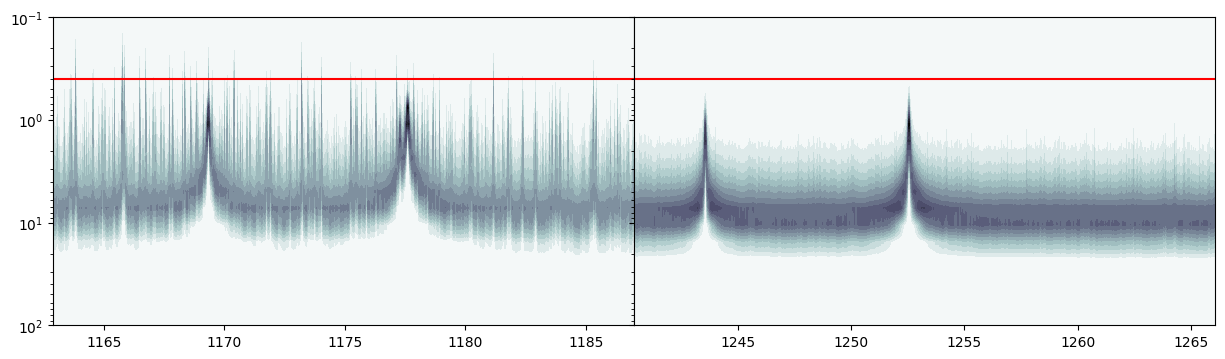

In [46]:
import petitRADTRANS.nat_cst as nc

fig, ax = plt.subplots(figsize=(15,4), ncols=2, sharey=True, gridspec_kw={'wspace':0.0})

order = 2
# Convert [cm] -> [nm]
m_wave = nc.c/pRT_atm.atm[order].freq * 1e7

X, Y = np.meshgrid(m_wave, PT.pressure)
ax[0].contourf(X, Y, pRT_atm.atm[order].contr_em, 15, cmap=plt.cm.bone_r)

order = 5
# Convert [cm] -> [nm]
m_wave = nc.c/pRT_atm.atm[order].freq * 1e7

X, Y = np.meshgrid(m_wave, PT.pressure)
ax[1].contourf(X, Y, pRT_atm.atm[order].contr_em, 15, cmap=plt.cm.bone_r)

for ax_i in ax:
    ax_i.axhline(10**(-0.4), c='r')

ax[0].set(yscale='log', ylim=(1e-1,1e2))
ax[0].invert_yaxis()

plt.savefig('./plots/K_lines_contr_em.pdf')
plt.show()

## Cloud condensation

In [ ]:
def cloud_condensation_curves(pressure, FeH, cloud_species):

    coeffs = {
        'CaTiO3': [5.125, -0.277, -0.554], # Wakeford et al. (2017)
        'Fe': [5.44, -0.48, -0.48], # Visscher et al. (2010)
        'Mg2SiO4': [5.89, -0.37, -0.73], # Visscher et al. (2010)
        'MgSiO3': [6.26, -0.35, -0.70], # Visscher et al. (2010)
        'Cr': [6.576, -0.486, -0.486], # Morley et al. (2012)
        'KCl': [12.479, -0.879, -0.879], # Morley et al. (2012)
        'MnS': [7.45, -0.42, -0.84], # Visscher et al. (2006)
        'Na2S': [10.05, -0.72, -1.08], # Visscher et al. (2006)
        'ZnS': [12.52, -0.63, -1.26], # Visscher et al. (2006)
        'H2S': [86.49, -8.54, -8.54], # Visscher et al. (2006)
    }

    a, b, c = coeffs[cloud_species]
    
    y = a + b*np.log10(pressure) + c*FeH
    T = 1e4/y

    return T

pressure = 10**np.linspace(-6,2,50)
T_cond = cloud_condensation_curves(pressure, 0, 'KCl')

plt.figure(figsize=(6,6))
plt.plot(T_cond, pressure)
plt.yscale('log')
plt.ylim(1e2,1e-6)
plt.xlim(1,3500)
plt.show()